# Importando Bibliotecas

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#Plot
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# Processamento
import numpy as np
import random
import pandas as pd
import time
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import itertools

# Outros
import warnings

In [2]:
warnings.filterwarnings("ignore", message="Do not pass an `input_shape`/`input_dim` argument to a layer.")

Definindo uma seed padrão, para manter uma constância nos resultados, caso seja necessário rodar o projeto novamente

In [3]:
seed = 42
np.random.seed(seed)
random.seed(seed)

Selecionando o dispositivo para rodar o projeto (Prefencialmente GPU)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Carregando e Processando os Dados

Iremos trabalhar com o valor de fechamento do BTC no dia, então iremos remover o valor de abertura do dataset

In [5]:
dataset = pd.read_csv('../data/Bitstamp_BTCUSD_d.csv')

Transformando a coluna *date* para o formato de dateTime


In [6]:
dataset['date'] = pd.to_datetime(dataset['date'])

dataset

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1717459200,2024-06-04,BTC/USD,68798.00,68868.00,68792.00,68857.00,6.283420e-01,4.326574e+04
1,1717372800,2024-06-03,BTC/USD,67744.00,70268.00,67590.00,68801.00,2.391376e+03,1.645291e+08
2,1717286400,2024-06-02,BTC/USD,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07
3,1717200000,2024-06-01,BTC/USD,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07
4,1717113600,2024-05-31,BTC/USD,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08
...,...,...,...,...,...,...,...,...,...
3472,1417478400,2014-12-02,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
3473,1417392000,2014-12-01,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
3474,1417305600,2014-11-30,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
3475,1417219200,2014-11-29,BTC/USD,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03


Podemos verificar que a coluna 'symbol' apenas um único valor para todas as instâncias, por isso vamor removê-la, esse valor inclusive não será importante na predição

In [7]:
dataset['symbol'].describe()

count        3477
unique          1
top       BTC/USD
freq         3477
Name: symbol, dtype: object

In [8]:
dataset.drop(['symbol'], axis=1, inplace=True)

Agora iremos configurar a coluna de data para ser o index do dataset. Além disso, iremos remover instâncias que possuem alguma coluna com valor NA ou que sejam duplicatas.

In [9]:
# Configura a coluna de data como index do Dataframe
dataset.set_index('date', inplace=True, drop=False)
dataset = dataset.reset_index(drop=True)

# Verificar e remover valores nulos
dataset = dataset.dropna()

# Verificar e remover duplicatas
dataset = dataset.drop_duplicates()

# Análise Exploratória

In [11]:
dataset

,unix,date,open,high,low,close,Volume BTC,Volume USD
0,1717459200,2024-06-04,68798.00,68868.00,68792.00,68857.00,6.283420e-01,4.326574e+04
1,1717372800,2024-06-03,67744.00,70268.00,67590.00,68801.00,2.391376e+03,1.645291e+08
2,1717286400,2024-06-02,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07
3,1717200000,2024-06-01,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07
4,1717113600,2024-05-31,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08
...,...,...,...,...,...,...,...,...
3472,1417478400,2014-12-02,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
3473,1417392000,2014-12-01,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
3474,1417305600,2014-11-30,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
3475,1417219200,2014-11-29,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03


Pegando o número de linhas equivalente a 20% do dataset. Essa quantidade será importante para definir o tamanho do conjunto de treinamento e teste

In [12]:
num_linhas = int(len(dataset) * 0.2)

### Plotando o valor de BTC ao longo do tempo

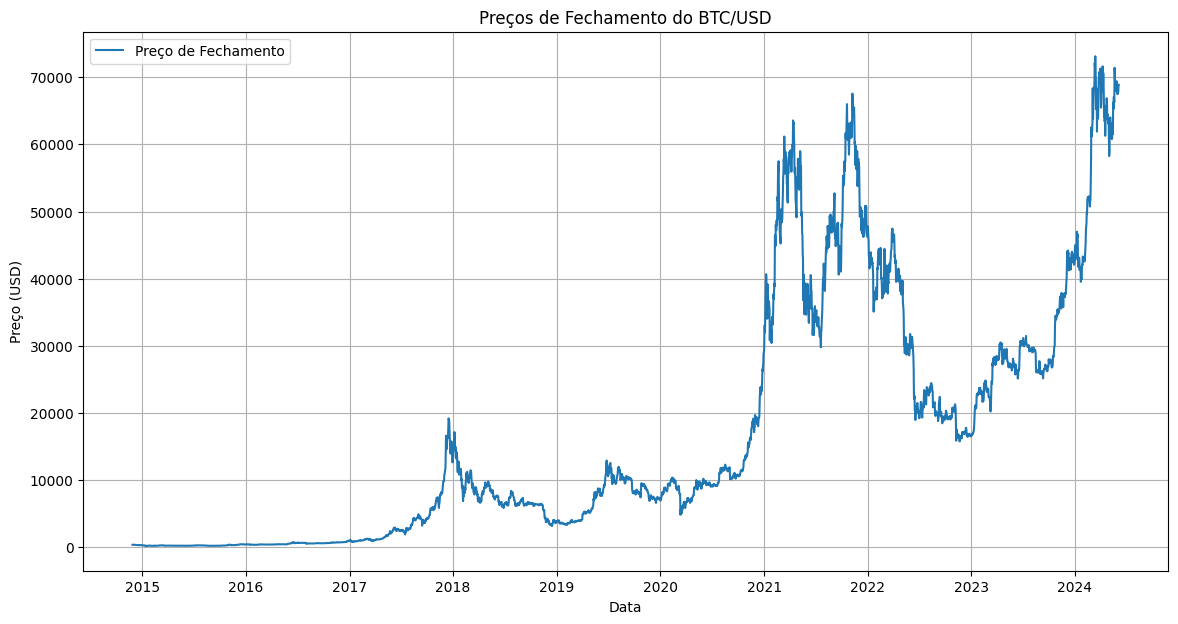

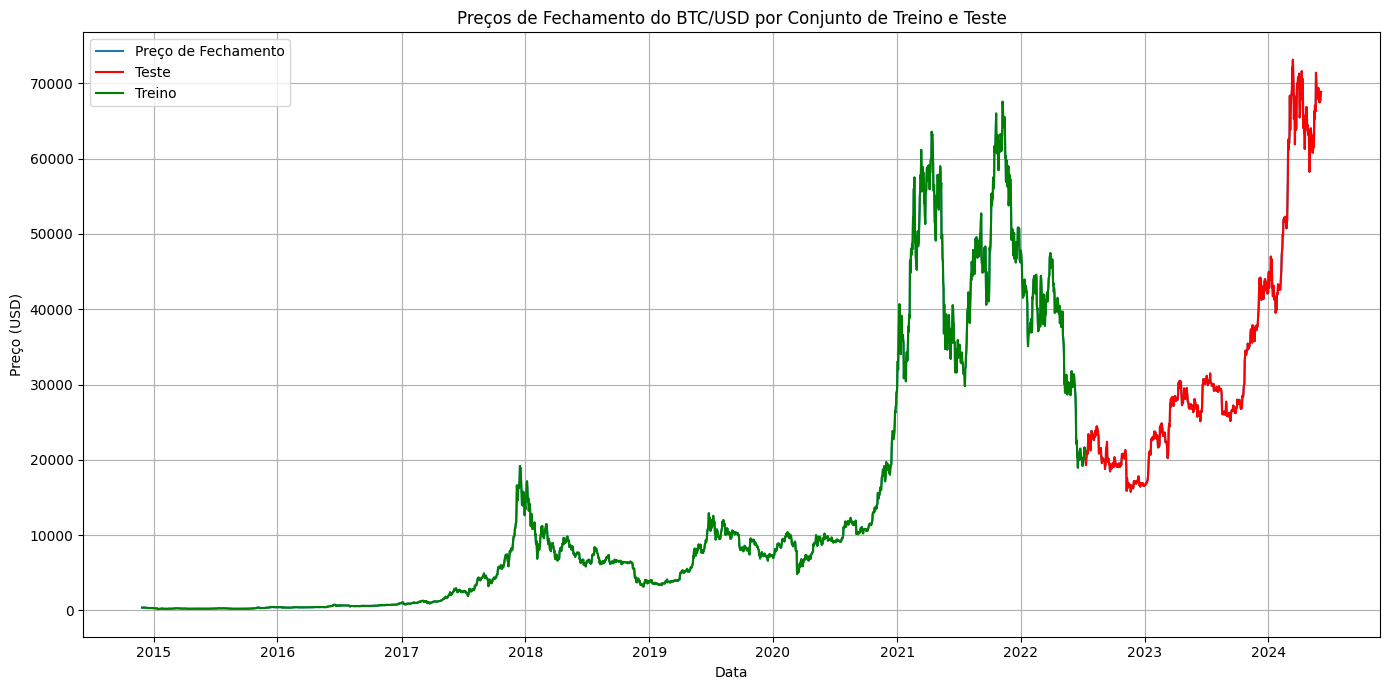

In [13]:
# Plotar os preços de fechamento ao longo do tempo
plt.figure(figsize=(14, 7))
plt.plot(dataset['date'], dataset['close'], label='Preço de Fechamento')
plt.title('Preços de Fechamento do BTC/USD')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)

# Plotar os preços de fechamento do conjunto de treino e teste
plt.figure(figsize=(14, 7))
plt.plot(dataset['date'], dataset['close'], label='Preço de Fechamento')
plt.plot(dataset.iloc[:num_linhas]['date'], dataset.iloc[:num_linhas]['close'], label='Teste', color='red')
plt.plot(dataset.iloc[num_linhas:]['date'], dataset.iloc[num_linhas:]['close'], label='Treino', color='green')
plt.title('Preços de Fechamento do BTC/USD por Conjunto de Treino e Teste')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Plotando o volume negociado ao longo do tempo

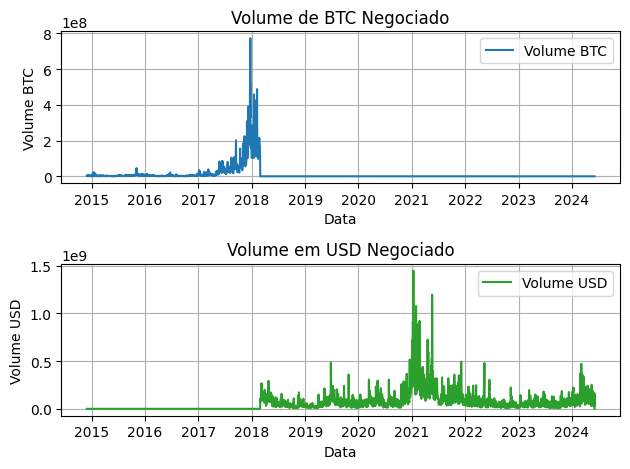

In [14]:
plt.subplot(2, 1, 1)
plt.plot(dataset['date'], dataset['Volume BTC'], label='Volume BTC', color='tab:blue')
plt.title('Volume de BTC Negociado')
plt.xlabel('Data')
plt.ylabel('Volume BTC')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(dataset['date'], dataset['Volume USD'], label='Volume USD', color='tab:green')
plt.title('Volume em USD Negociado')
plt.xlabel('Data')
plt.ylabel('Volume USD')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Exibindo a matriz de correlação entre as features do projeto

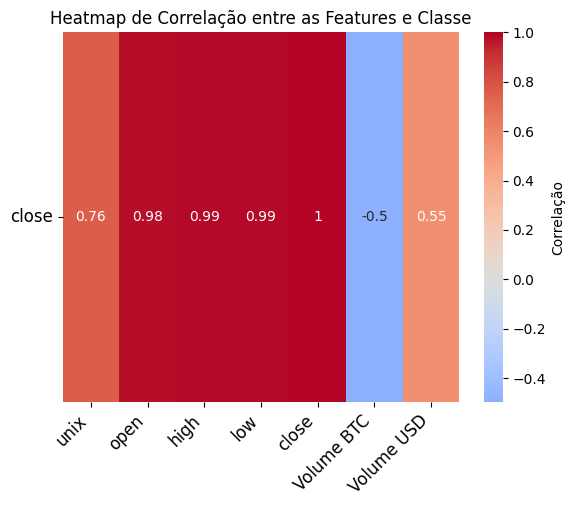

In [15]:
# Calcular a correlação entre preço e volume
correlation = dataset.corr(method='kendall', numeric_only=True)

sns.heatmap(correlation[['close']].T, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlação'})
plt.title('Heatmap de Correlação entre as Features e Classe')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

Faz todo sentido que os valores de *open*, *high*, *low*, *close*, possuam uma alta correlação, uma vez que o valor do BTC não sofre grande variações ao longo dos dias, logo esses valores tendem a serem muito próximos ums dos outros, além de representarem a mesma caracteristica, o preço do BTC

# Divisão dos Dados

Retiriando dados inúteis e normalizando os dados

In [16]:
# ['date', 'unix', 'open', 'low', 'high', 'Volume USD', 'Volume BTC']
dp_dataset = dataset.drop(['date', 'unix', 'open', 'low', 'high'], axis=1)

# Normaliza os dados
scaler = MinMaxScaler(feature_range=(0, 1))
sc_dataset = scaler.fit_transform(dp_dataset)

In [17]:
dp_dataset

,open,high,low,close,Volume BTC,Volume USD
0,68798.00,68868.00,68792.00,68857.00,6.283420e-01,4.326574e+04
1,67744.00,70268.00,67590.00,68801.00,2.391376e+03,1.645291e+08
2,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07
3,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07
4,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08
...,...,...,...,...,...,...
3472,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
3473,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
3474,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
3475,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03


In [18]:
sc_dataset

array([[9.40631510e-01, 9.33053515e-01, 9.64207250e-01, 9.41556217e-01,
        8.13567301e-10, 2.99183890e-05],
       [9.26186822e-01, 9.52080125e-01, 9.47322286e-01, 9.40788662e-01,
        3.09631584e-06, 1.13772323e-01],
       [9.25885320e-01, 9.26761144e-01, 9.42981643e-01, 9.26410724e-01,
        7.04829553e-07, 2.55036798e-02],
       ...,
       [2.94060410e-03, 2.29882214e-03, 3.10334946e-03, 2.89669540e-03,
        1.48326158e-03, 2.10654612e-06],
       [2.93854840e-03, 2.36147405e-03, 3.08831875e-03, 2.94302279e-03,
        3.55568085e-03, 5.01007010e-06],
       [2.76271790e-03, 2.28998836e-03, 2.92424523e-03, 2.93699201e-03,
        4.17034228e-03, 5.95878446e-06]])

In [19]:
sc_dataset.shape

(3477, 6)

#### Função para transformar uma série temporal em conjuntos de dados de treinamento, validação e teste para modelagem preditiva, utilizando uma janela deslizante para extrair sequências de entradas passadas e prever valores futuros.

In [20]:
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []
    
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])
    
    split_training_test_starting_point = int(round(train_test_split_percentage * len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point * (1 - validation_split_percentage)))
    
    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]
    
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val = y_data[split_train_validation_starting_point:split_training_test_starting_point]
    
    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]
    
    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

Criando o conjunto de test e validação a partir da definição de janela flutuante. Definindo a quantidade de dias passados serão utilizados na predição do futuro. Bem como na definição de quantos dias futuros queremos prever

In [21]:
n_future = 1 # -> Number of days you want to predict into the future
n_past = 3 # -> Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(
    sc_dataset, n_future=n_future, n_past=n_past, train_test_split_percentage=0.75, validation_split_percentage=0
)

In [22]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2606, 3, 6)
y_train shape: (2606, 1)
X_val shape: (0,)
y_val shape: (0,)
X_test shape: (868, 3, 6)
y_test shape: (868, 1)


# Treinando o Modelo LSTM

Treinando um modelo base, a fim de verificar o seu funcionamento. O modelo base tem 2 layers com 15 neurônios.

In [23]:
regressor = Sequential()
regressor.add(LSTM(units=15, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=15, return_sequences=False))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 15)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 15)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,196 (12.48 KB)

 Trainable params: 3,196 (12.48 KB)

 Non-trainable params: 0 (0.00 B)

Definimos um EarlyStop, com uma paciencia de 13

In [24]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=13)

# fit model
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=75, batch_size=16, callbacks=[es])

Epoch 1/75
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1004 - root_mean_squared_error: 0.3089 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0853
Epoch 2/75
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1116 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 3/75
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - root_mean_squared_error: 0.0968 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 4/75
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - root_mean_squared_error: 0.0907 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0358
Epoch 5/75
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 9.0674e-04 - val_root_mean_squared_error: 0.0301
Epoch 6/75
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - root_mean_squared_error: 0.0783 - val_loss: 9.9722e-04 - val_root_mean_squared_error: 0.0316
Epoch 7/75
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3

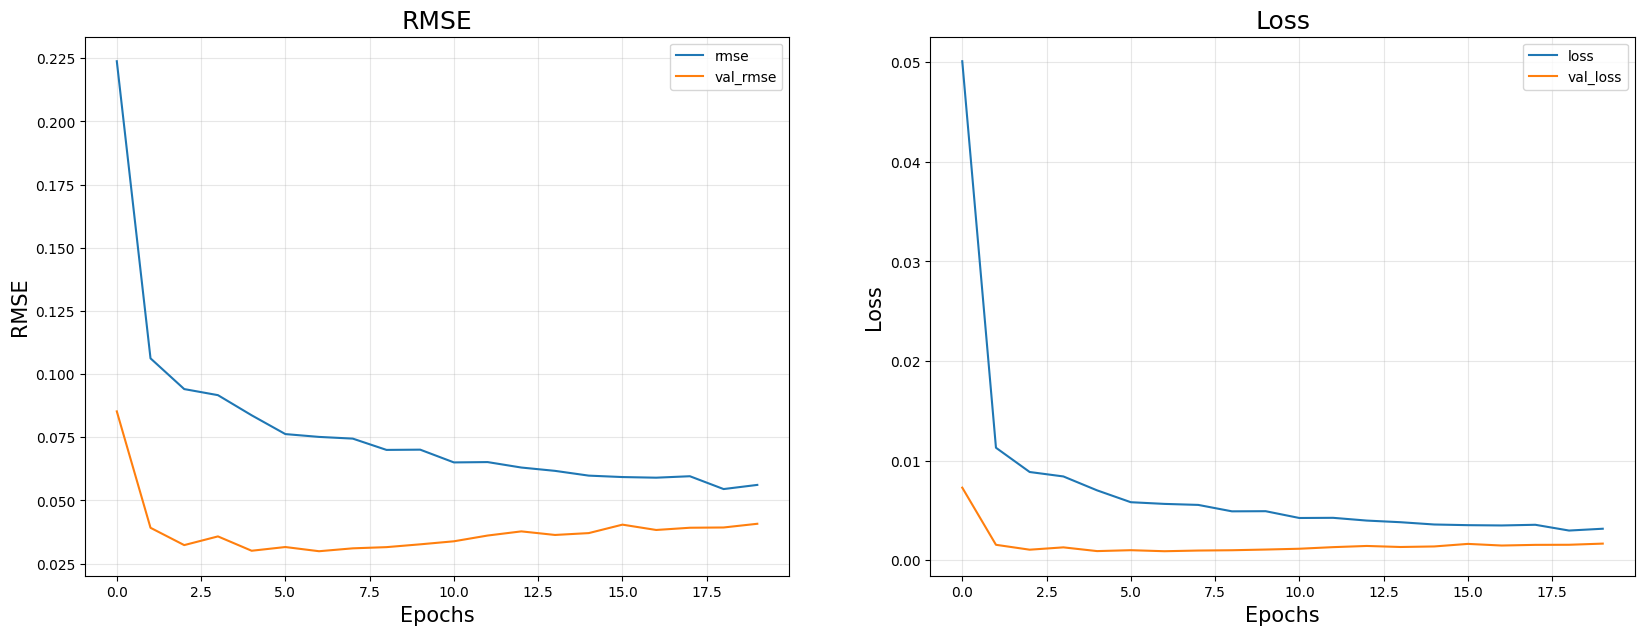

In [25]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

# Tunning

#### Função utilizada para a afinação de hiperparâmetros testando todas as combinações possíveis de: 
- camadas adicionais
- número de neurônios
- tamanho do batch 
- taxa de dropout
  
Para isso, há o treinamento e avaliação do modelo em cada combinação, utilizando callbacks para otimizar o processo de treinamento, mantendo um earlyStop relativamente baixo. Também criamos um modelCheckpoint para ir salvando o modelo ao longo do treinamento a fim de obter um backup ao final

A função retorna um histórico (hist) contendo as configurações testadas e suas respectivas MSE de treinamento e teste.

In [26]:
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

        file_path = f'../models/model_{i}.keras'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

Criação dos Conjuntos de Dados

In [27]:
n_future = 1 # -> Number of days you want to predict into the future
n_past = 3 #   -> Number of past days you want to use to predict the future

X_train, X_test, _, y_train, y_test, _ = create_data(
    sc_dataset, n_future=n_future, n_past=n_past, train_test_split_percentage=0.75, validation_split_percentage=0
)

Criando os possíveis parâmetros para o modelo, fizemos de modo a explorar possíveis combinações e camadas de neurônios, de modo que não tomasse um grande tempo de treinamento, mas que pudessemos ter uma ideia da melhor combinação de parâmetros

In [28]:
config = [
    [False, True], # -> [first_additional_layer]
    [False, True], # -> [second_additional_layer]
    [False, True], # -> [third_additional_layer]
    [16, 32], #      -> [n_neurons]
    [8, 16, 32], #   -> [n_batch_size]
    [0.2] #          -> [dropout_rate]
]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2), (False, False, True, 16, 8, 0.2), (False, False, True, 16, 16, 0.2), (False, False, True, 16, 32, 0.2), (False, False, True, 32, 8, 0.2), (False, False, True, 32, 16, 0.2), (False, False, True, 32, 32, 0.2), (False, True, False, 16, 8, 0.2), (False, True, False, 16, 16, 0.2), (False, True, False, 16, 32, 0.2), (False, True, False, 32, 8, 0.2), (False, True, False, 32, 16, 0.2), (False, True, False, 32, 32, 0.2), (False, True, True, 16, 8, 0.2), (False, True, True, 16, 16, 0.2), (False, True, True, 16, 32, 0.2), (False, True, True, 32, 8, 0.2), (False, True, True, 32, 16, 0.2), (False, True, True, 32, 32, 0.2), (True, False, False, 16, 8, 0.2), (True, False, False, 16, 16, 0.2), (True, False, False, 16, 32, 0.2), (True, False, False, 32, 8, 0.2), (True, False, False, 32, 16, 

Após o Fine-Tunning obtivemos a seguinte tabela, com os melhores resultados de treinamento

In [29]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True).reset_index()
hist.head()

,index,0,1,2,3,4,5,6,7
0,3,False,False,False,32,8,0.2,"[0.0005157681880518794, 0.02278803661465645]","[1.0468103027960751e-05, 0.0032251584343612194]"
1,15,False,True,False,32,8,0.2,"[0.0006495684501715004, 0.02557123638689518]","[4.195947985863313e-05, 0.0064655328169465065]"
2,22,False,True,True,32,16,0.2,"[0.0010056281462311745, 0.03181815892457962]","[4.2651572584873065e-05, 0.006523159332573414]"
3,9,False,False,True,32,8,0.2,"[0.0006272193277254701, 0.02512061968445778]","[5.991946818539873e-05, 0.007749869488179684]"
4,5,False,False,False,32,32,0.2,"[0.0005652936524711549, 0.023847907781600952]","[8.9936402218882e-05, 0.009468619711697102]"


Os modelos com maior número de neurônios (32) obtiveram os melhores resultados. No entanto, o número de camadas não apresentou uma grande influência no MSE, uma vez que, dos 5 melhores modelos, 2 possuíam apenas uma camada de LSTM. Isso evidencia que não é necessário uma rede muito complexa para resolver o problema.

Outro hiperparâmetro que podemos destacar é o batch_size, em que valores menores (8) resultaram em melhores desempenhos na loss do modelo. Isso pode ser explicado pelo fato de que batch_sizes menores introduzem mais variabilidade nos gradientes durante o treinamento, o que pode ajudar o modelo a escapar de mínimos locais e generalizar melhor. Em contrapartida, batch_sizes maiores fornecem atualizações mais estáveis, mas podem dificultar a capacidade do modelo de encontrar padrões, especialmente em conjuntos de dados menores.

Carregando o melhor modelo

In [30]:
idx_best_model = hist.loc[0, 'index']
print(idx_best_model)
regressor = load_model(f'../models/model_{idx_best_model}.keras')

3


# Testando o modelo

In [31]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test MSE:", np.round(results, 7))

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.8054e-04 - root_mean_squared_error: 0.0134
test loss, test acc: [0.0001952 0.0139551]


### Plotando o gráfico do valor real do BTC x Valor predizido

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


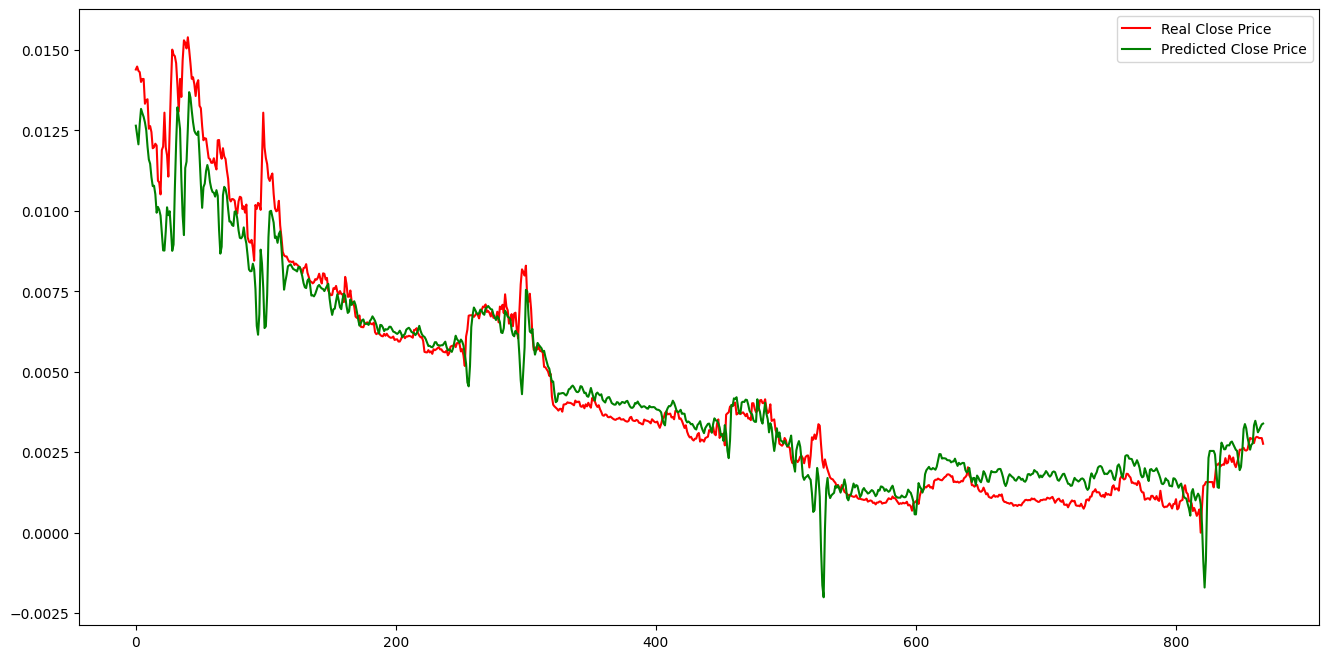

In [37]:
y_pred = regressor.predict(X_test)
y_pred = y_pred - 0.014 
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Close Price')
plt.plot(y_pred, color='green', label = 'Predicted Close Price')
plt.legend(loc='best')

Dado que os dados foram normalizados durante o treinamento, é possível observar que o modelo apresentou um gráfico bastante semelhante ao valor real do BTC, com uma margem de erro bastante reduzida. No entanto, o desempenho do modelo se mostra inferior quando há grandes alterações no mercado. Isso pode ser explicado por movimentos inesperados, que não seguem padrões matemáticos, mas sim reações a acontecimentos externos, como a criação de novas legislações ou a falência de alguma corretora.

Melhor Modelo:
- Additional_layer : 1
- n_neurons: 32
- n_batch_size: 8
- dropout_rate: 0.2

MSE: 0.0134


# Análise do resultados Fine - Tunning


Realizamos o mesmo processo de fine-tuning utilizando a combinação dos parâmetros

- Um layer Adicional
- Segundo Layer Adicional
- Terceiro Layer Adicional
- Número de Neurônios
- Tamanho do Batch Size
- Dropout Rate

Além de variar esses valores, decidimos realizar o fine-tunnning variando o tamnanho da janela de dias passados utilizados para a predição futura, variamos esse valor em 3, 7 e 14. Como será exemplificado nos gráficos abaixo, a janela com 3 dias apresentou os melhor resultado, ainda assim é importante visualizar que janelas maiores apresentaram erros médios menores.

importando os datasets

In [24]:
dt_3d = pd.read_csv('../csv/saves_3d.csv')
dt_3d['window'] = 3


In [25]:
dt_7d = pd.read_csv('../csv/saves_7d.csv')
dt_7d['window'] = 7

In [26]:
dt_14d = pd.read_csv('../csv/saves_14d.csv')
dt_14d['window'] = 14

Unindo os datasets

In [74]:
df = pd.concat([dt_3d, dt_14d, dt_7d], ignore_index=True)

Realizando uma limpeza e unindo alguns dados

In [75]:
df['n_additional_layer'] = df[['0', '1', '2']].sum(axis=1)
df.drop(columns=['0', '1', '2', 'index', 'Unnamed: 0'], inplace=True)


In [79]:
df['7'] = df['7'].apply(lambda x: x.split(',')[1].strip() if ',' in x else None)
df['7'] = df['7'].apply(lambda x: x[:-2])
df['7'] = df['7'].astype(float)



In [54]:
df['7']

0      0.0021100558806210756]
1      0.0021100558806210756]
2      0.0021100558806210756]
3      0.0021100558806210756]
4      0.0021100558806210756]
                ...          
139    0.0021100558806210756]
140    0.0021100558806210756]
141    0.0021100558806210756]
142    0.0021100558806210756]
143    0.0021100558806210756]
Name: 7, Length: 144, dtype: object

In [83]:
df

,3,4,5,6,7,window,n_additional_layer
0,32,16,0.2,"[0.000356823846232146, 0.01895478367805481]",0.000818,3,0
1,32,16,0.2,"[0.0004492134612519294, 0.02126694843173027]",0.002110,3,1
2,32,16,0.2,"[0.00043258810183033347, 0.0208661537617445]",0.005017,3,1
3,32,8,0.2,"[0.0004336281563155353, 0.0208913404494524]",0.005166,3,1
4,32,32,0.2,"[0.0005631007952615619, 0.02380681224167347]",0.005358,3,1
...,...,...,...,...,...,...,...
139,16,32,0.2,"[0.0012289963196963072, 0.035058192908763885]",0.036351,7,2
140,16,8,0.2,"[0.0014935885556042194, 0.03867044299840927]",0.038763,7,2
141,16,8,0.2,"[0.001195003860630095, 0.03448626026511192]",0.044633,7,2
142,32,8,0.2,"[0.0029087993316352367, 0.05400223284959793]",0.044884,7,2


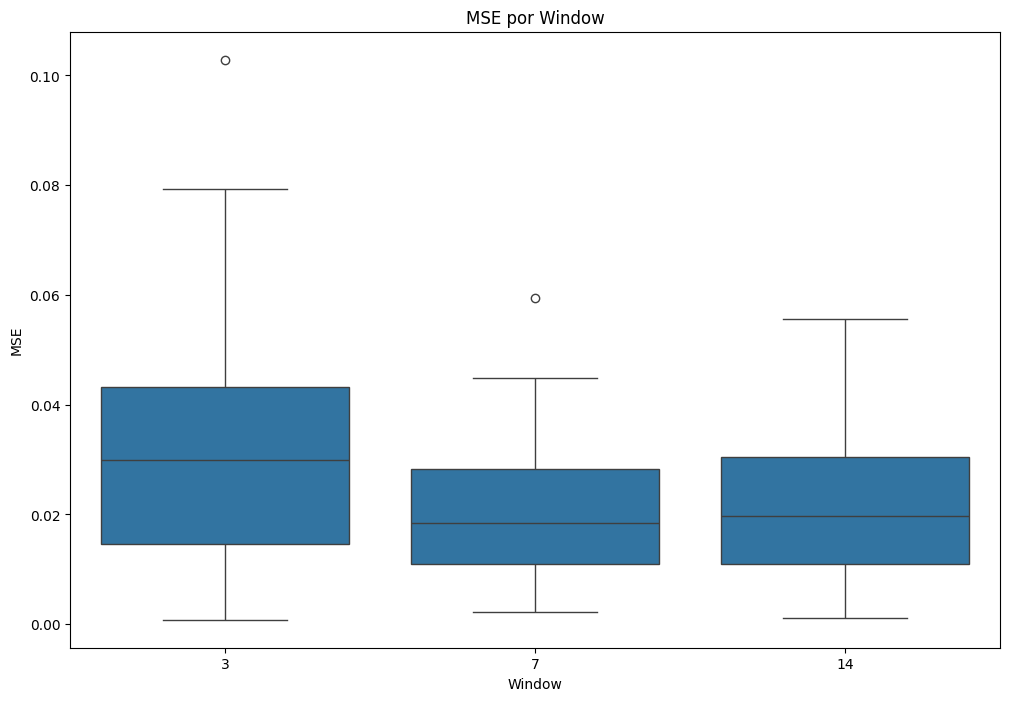

In [90]:
# Criando o boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='window', y='7', data=df)  # Assumindo que a coluna 7 é numérica

# Personalizando o gráfico
plt.title('MSE por Window')
plt.xlabel('Window')
plt.ylabel('MSE')

plt.show()

Como demonstrado no gráfico, os modelos com janelas de 3 dias exibem maior variabilidade no MSE. Isso ocorre porque, com janelas menores, há menos dados disponíveis para previsão, o que pode dificultar a obtenção de resultados precisos sem um período de treinamento mais extenso. Curiosamente, o melhor modelo encontrado foi o com a janela de 3 dias, ainda assim, para períodos de tempos maiores possam haver potenciais desafios para sua aplicação. De modo geral, os modelos com janelas de 7 dias apresentaram um desvio padrão no MSE menor, indicando que esses podem ser mais generalistas e oferecem um melhor equilíbrio entre estabilidade e precisão. Por outro lado, os modelos com janelas de 14 dias mostraram um desvio padrão maior, possivelmente devido à complexidade introduzida pelo maior volume de dados, o que requer um tempo de treinamento mais longo.

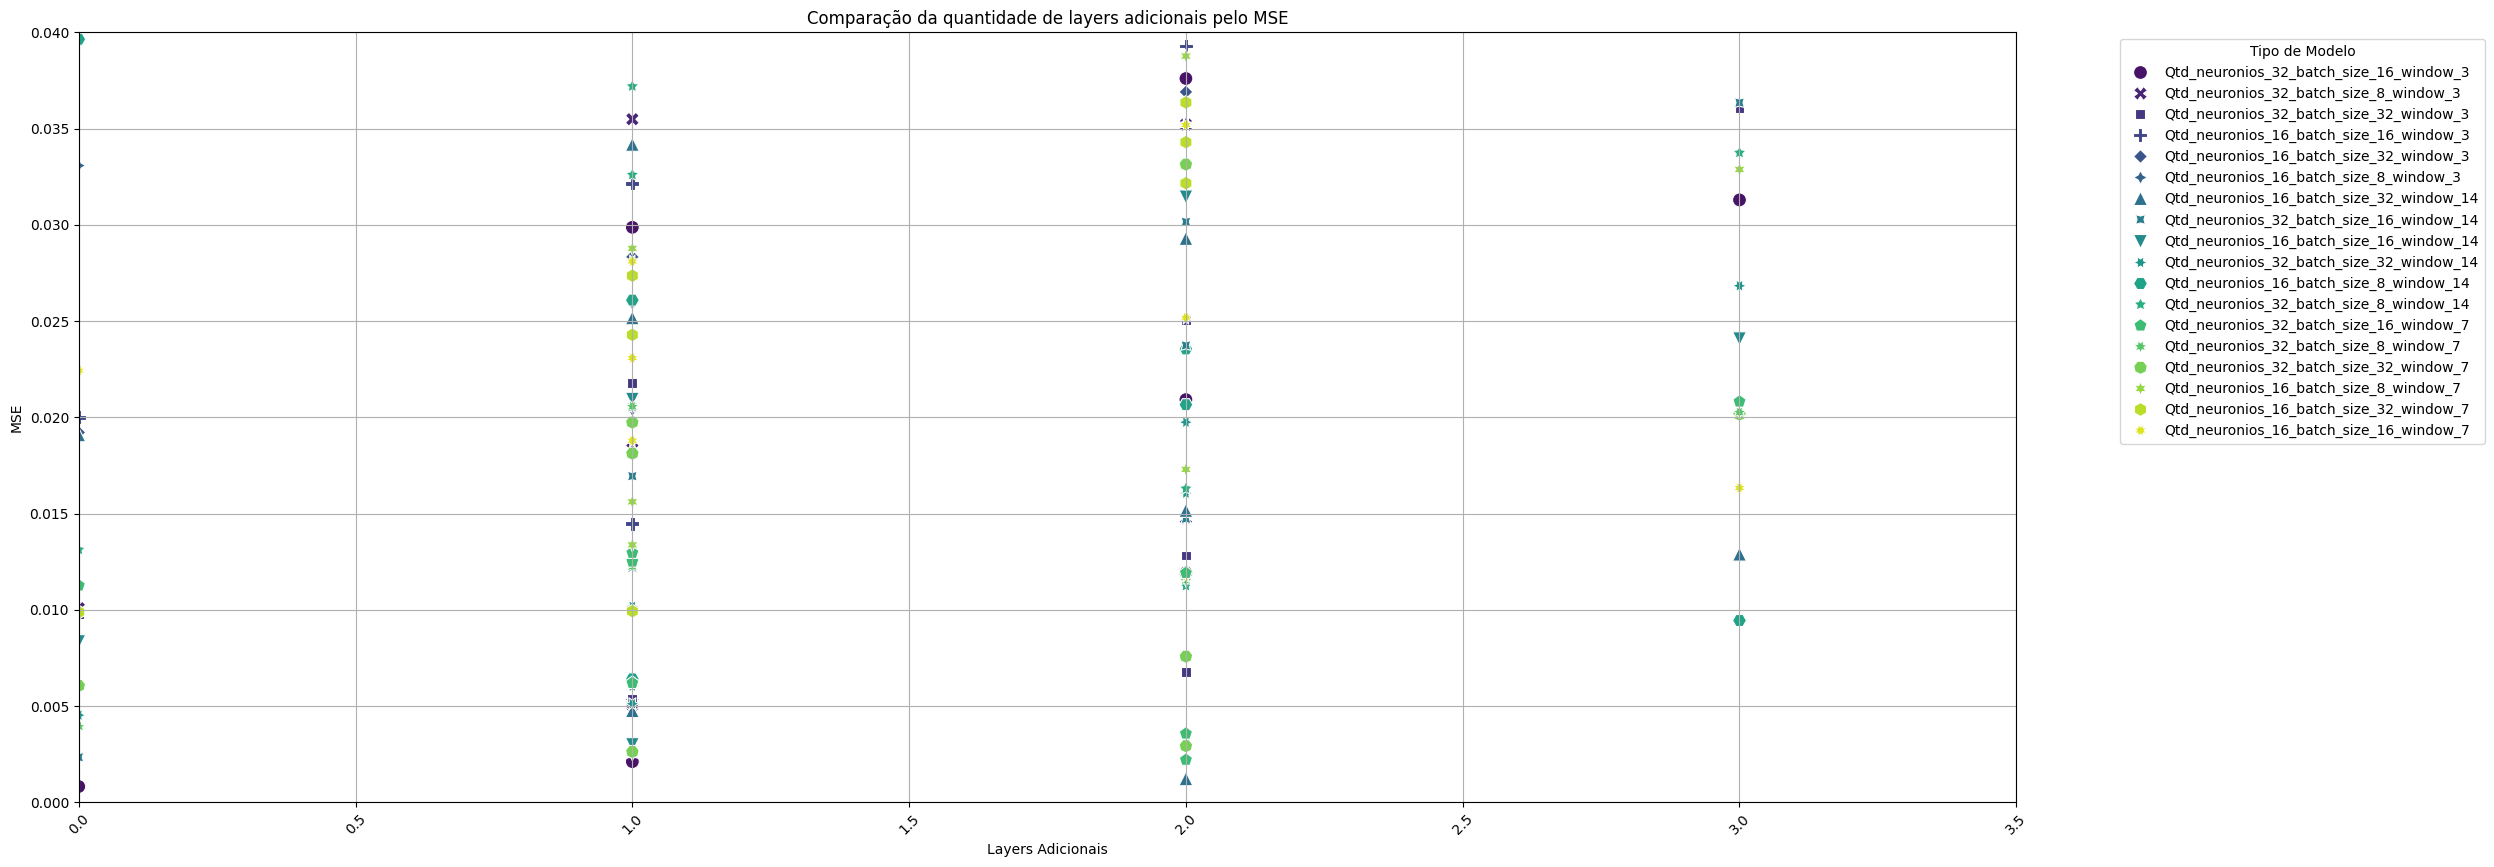

In [102]:
plt.figure(figsize=(25, 10))

df['model_type'] = ('Qtd_neuronios_' + df['3'].astype(str) + 
                    '_batch_size_' + df['4'].astype(str) + 
                    '_window_' + df['window'].astype(str))

# Plotando o gráfico de dispersão
sns.scatterplot(data=df, x='n_additional_layer', y='7', hue='model_type', style='model_type',
                markers=True, palette='viridis', s=100)

# Personalizando o gráfico
plt.title('Comparação da quantidade de layers adicionais pelo MSE')
plt.xlabel('Layers Adicionais')
plt.ylabel('MSE')

plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left') 

plt.xlim(0, 3.5)  
plt.ylim(0, 0.04) 

plt.show()


Interpretando o gráfico é possível observar que o aumento no número de layers de LSTM não apresentou um ganho de performance do modelo, em alguns casos houve até uma piora significativa do modelo

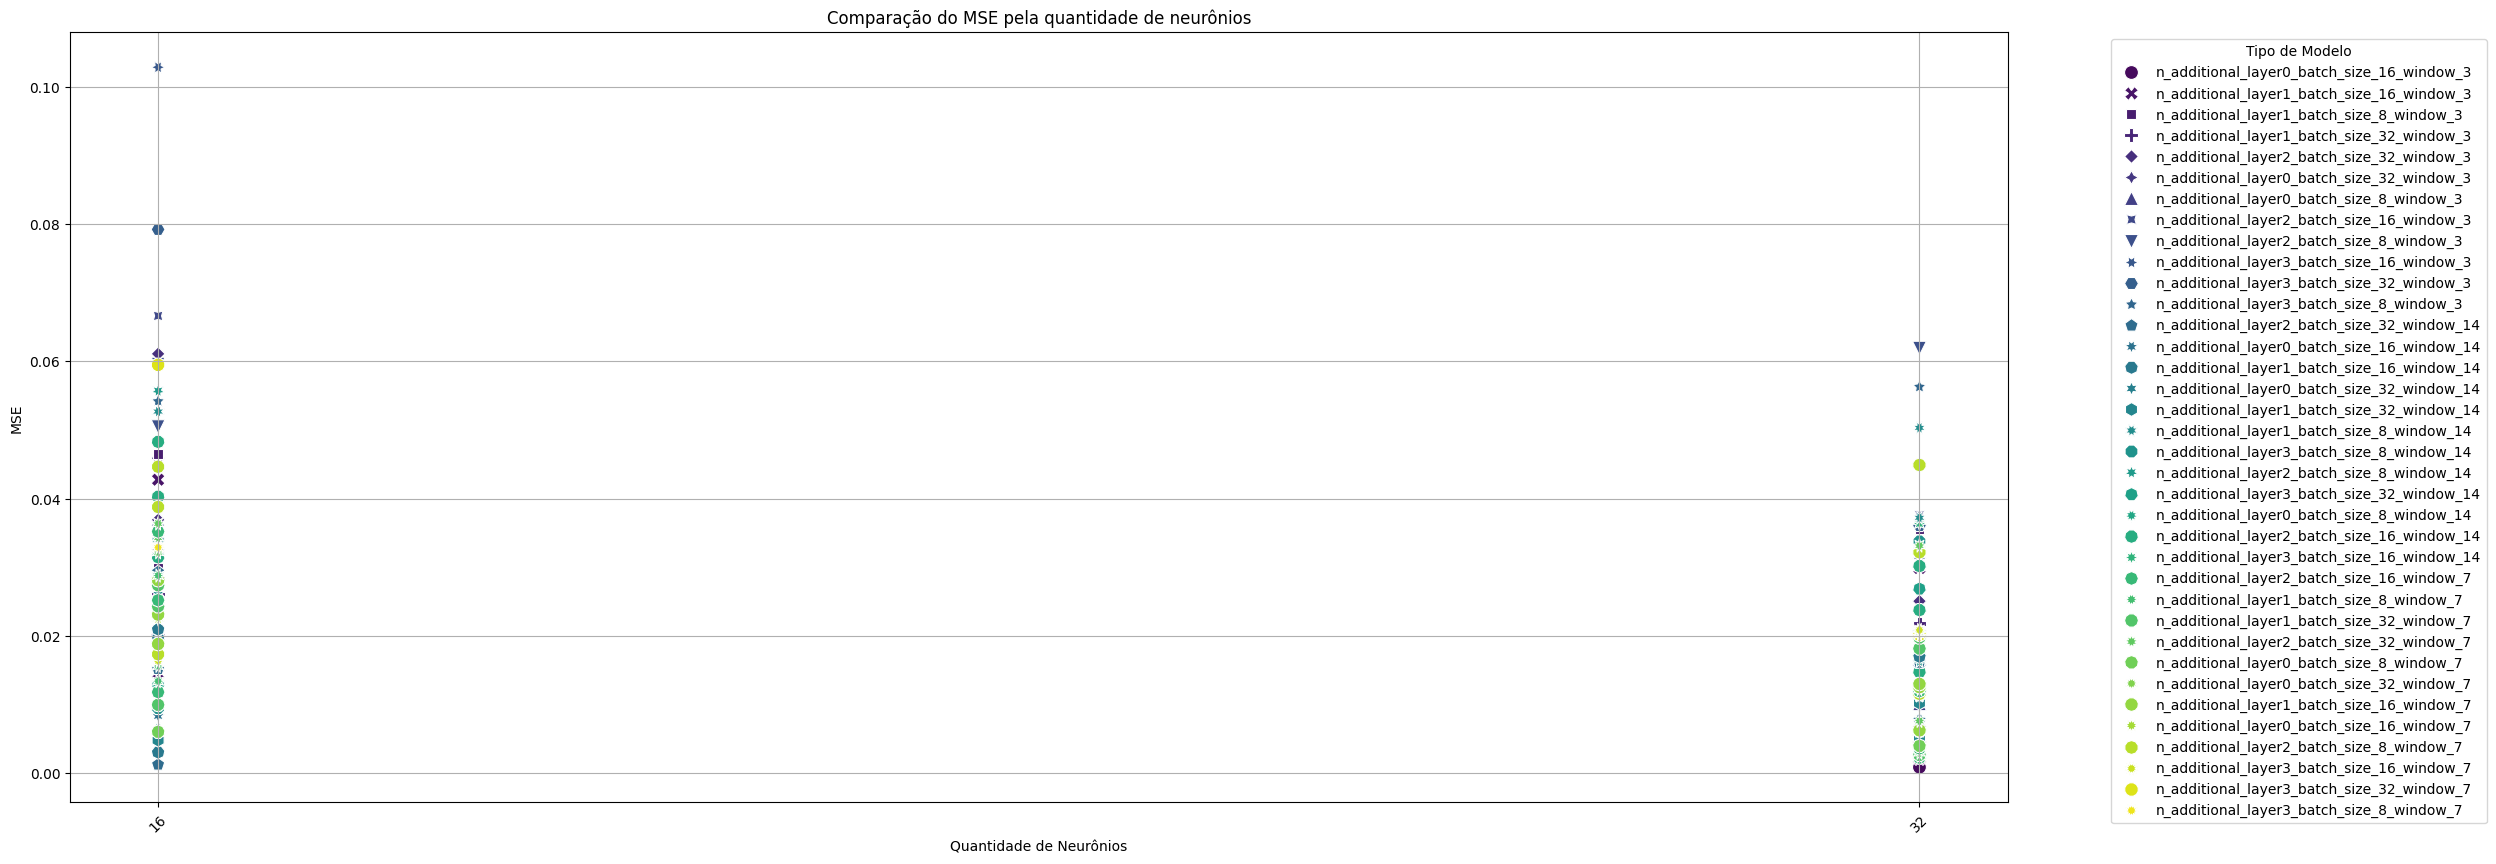

In [101]:
plt.figure(figsize=(25, 10))

df['model_type'] = ('n_additional_layer' + df['n_additional_layer'].astype(str) + 
                    '_batch_size_' + df['4'].astype(str) + 
                    '_window_' + df['window'].astype(str))

# Plotando o gráfico de dispersão
sns.scatterplot(data=df, x='3', y='7', hue='model_type', style='model_type',
                markers=True, palette='viridis', s=100)

# Personalizando o gráfico
plt.title('Comparação quantidade de neurônios pelo MSE')
plt.xlabel('Quantidade de Neurônios')
plt.ylabel('MSE')

plt.xticks(rotation=45, ticks=[16,32])
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left') 


plt.show()


Podemos observar que o aumento na quantidade de neurônios traz uma melhora siginificativa no RMSE, o que pode ser explicado pela complexiadade do problema, necessitando uma maior quantidade de neurônios para obter melhores resultados